In [149]:
import os
import pandas as pd
df = pd.read_parquet("../train_final_v3.parquet", engine="pyarrow")
print(df.shape)
print(df.columns[:20].tolist())

(112768, 791)
['category', 'missing_price', 'item_rank', 'match', 'avg_rating', 'min_rating', 'percent_positive', 'percent_negative', 'avg_verified_reviewers', 'min_date', 'max_date', 'product_lifespan', 'num_bots_per_asin', 'unique_reviewer_count', 'avg_reviews_per_day', 'reviews_per_product', 'avg_review_length_words', 'embed_0', 'embed_1', 'embed_2']


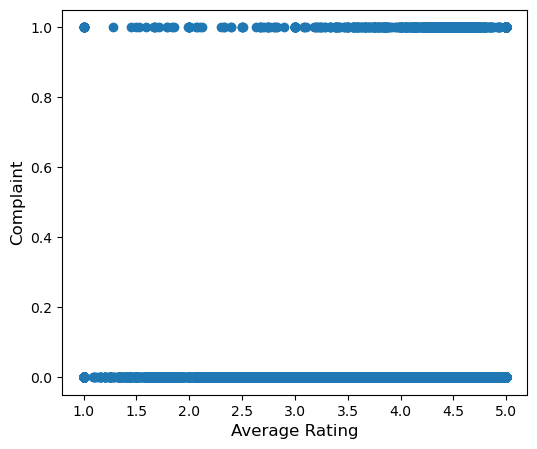

In [150]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))

plt.scatter(df['avg_rating'], df['match'])

plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("Complaint", fontsize=12)
plt.show()

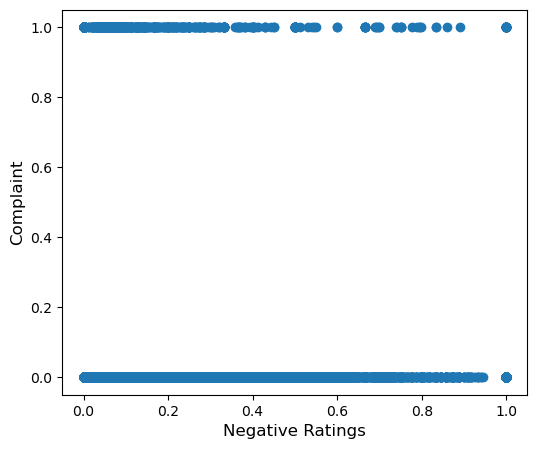

In [151]:
import matplotlib.pyplot as plt
plt.figure(figsize=(6,5))

plt.scatter(df['percent_negative'], df['match'])

plt.xlabel("Negative Ratings", fontsize=12)
plt.ylabel("Complaint", fontsize=12)
plt.show()

/var/folders/zz/p68469x91nz101jr8rs456_80000gq/T/ipykernel_82162/2274814827.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_means = df.groupby('rating_bin')['avg_rating'].mean()
/var/folders/zz/p68469x91nz101jr8rs456_80000gq/T/ipykernel_82162/2274814827.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  bin_rates = df.groupby('rating_bin')['match'].mean()


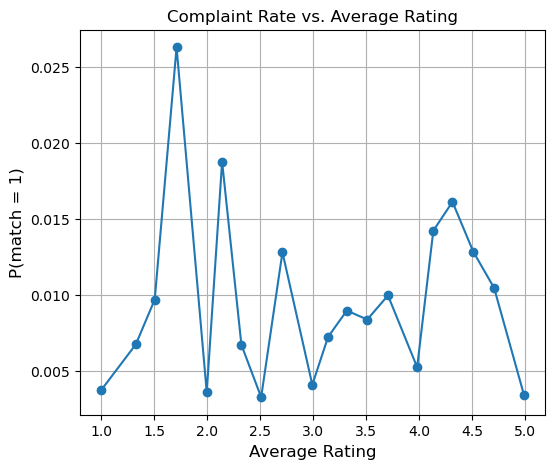

In [152]:
# Bin average ratings
df['rating_bin'] = pd.cut(df['avg_rating'], bins=20)

# Compute complaint rate per bin
bin_means = df.groupby('rating_bin')['avg_rating'].mean()
bin_rates = df.groupby('rating_bin')['match'].mean()

plt.figure(figsize=(6, 5))
plt.plot(bin_means, bin_rates, marker='o')
plt.xlabel("Average Rating", fontsize=12)
plt.ylabel("P(match = 1)", fontsize=12)
plt.title("Complaint Rate vs. Average Rating")
plt.grid(True)
plt.show()


In [ ]:
# Bin average ratings
df['rating_bin'] = pd.cut(df['percent_negative'], bins=20)

# Compute complaint rate per bin
bin_means = df.groupby('rating_bin')['percent_negative'].mean()
bin_rates = df.groupby('rating_bin')['match'].mean()

plt.figure(figsize=(6, 5))
plt.plot(bin_means, bin_rates, marker='o')
plt.xlabel("percent_negative", fontsize=12)
plt.ylabel("P(match = 1)", fontsize=12)
plt.title("Complaint Rate vs. percent_negative")
plt.grid(True)
plt.show()


In [153]:
import torch
import torch.nn as nn

# Increase weight on positive class (label = 1)
loss_bl = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]))  # Try 5.0, 10.0, etc.


In [154]:
def compute_baseline_loss_all_zeros(df, label_col="match", pos_weight=1.0, device="cpu"):
    """
    Compute baseline BCEWithLogitsLoss for a model that always predicts 0.

    Parameters:
    - df: pandas DataFrame containing the label column
    - label_col: name of the label column (default: "match")
    - pos_weight: float (how much more to penalize false negatives)
    - device: "cpu" or "cuda"

    Returns:
    - loss_value: float
    """
    y_true = torch.tensor(df[label_col].values, dtype=torch.float32).to(device)

    # Simulate prediction of all 0s → logits = -100
    y_pred_logits = torch.full_like(y_true, -100.0, device=device)

    pos_weight_tensor = torch.tensor([pos_weight], device=device)
    loss_bl = nn.BCEWithLogitsLoss(pos_weight=pos_weight_tensor)

    loss = loss_bl(y_pred_logits, y_true)
    return loss.item()


In [155]:
baseline_loss = compute_baseline_loss_all_zeros(df, label_col="match", pos_weight=10.0)
print("Baseline loss (predict all 0s):", baseline_loss)


Baseline loss (predict all 0s): 6.8104424476623535


In [156]:
import torch
import torch.nn as nn

# Convert 'avg_rating' and 'match' columns to PyTorch tensors
X_avg = torch.tensor(df[['avg_rating']].values, dtype=torch.float32)  # shape (N, 1)
y_avg = torch.tensor(df['match'].values, dtype=torch.float32).view(-1)  # shape (N,)


In [161]:
model_avg = nn.Linear(1, 1)  # Logistic regression: 1 feature → 1 logit output
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]))  # Penalize FN
optimizer = torch.optim.SGD(model_avg.parameters(), lr=0.01)


In [162]:
num_epochs = 1000

for epoch in range(num_epochs):
    model_avg.train()

    logits = model_avg(X).view(-1)
    loss = loss_fn(logits, y)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


Epoch 0, Loss: 1.1034
Epoch 100, Loss: 0.7819
Epoch 200, Loss: 0.5933
Epoch 300, Loss: 0.4819
Epoch 400, Loss: 0.4134
Epoch 500, Loss: 0.3694
Epoch 600, Loss: 0.3399
Epoch 700, Loss: 0.3193
Epoch 800, Loss: 0.3045
Epoch 900, Loss: 0.2937


In [169]:
model_avg.eval()
with torch.no_grad():
    logits = model_avg(X).view(-1)
    probs = torch.sigmoid(logits)


In [167]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# Step 1: Compute probabilities
with torch.no_grad():
    logits = model_avg(X_avg).view(-1)           # raw output from the model
    probs = torch.sigmoid(logits)        # convert logits to probabilities

# Step 2: Set custom threshold
threshold = 0.2
y_pred = (probs > threshold).int()       # predicted labels (0 or 1)

# Step 3: Ground truth
y_true = y.int()

# Step 4: Metrics
cm = confusion_matrix(y_true, y_pred)
TN, FP, FN, TP = cm.ravel()

precision = precision_score(y_true, y_pred, zero_division=0)
recall = recall_score(y_true, y_pred, zero_division=0)
f1 = f1_score(y_true, y_pred, zero_division=0)

# Step 5: Print results
print(f"Threshold: {threshold}")
print(f"TP: {TP}, TN: {TN}, FP: {FP}, FN: {FN}")
print(f"Precision: {precision:.3f}, Recall: {recall:.3f}, F1-score: {f1:.3f}")


Threshold: 0.2
TP: 597, TN: 26908, FP: 85092, FN: 171
Precision: 0.007, Recall: 0.777, F1-score: 0.014


In [ ]:
for name, param in model.named_parameters():
    print(f"{name}: {param.data}")


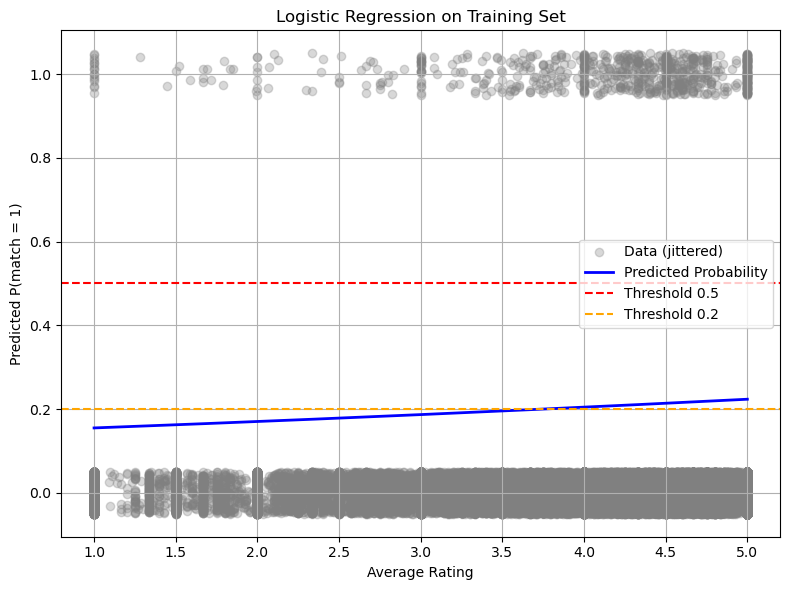

In [168]:
import matplotlib.pyplot as plt
import numpy as np

# Smooth curve
x_vals = torch.linspace(df['avg_rating'].min(), df['avg_rating'].max(), 200).view(-1, 1)

model_avg.eval()
with torch.no_grad():
    y_vals = torch.sigmoid(model_avg(x_vals)).view(-1).numpy()

# Jittered training points
x_scatter = df['avg_rating'].values
y_scatter = df['match'].values + np.random.uniform(-0.05, 0.05, size=len(df))

plt.figure(figsize=(8, 6))
plt.scatter(x_scatter, y_scatter, alpha=0.3, label="Data (jittered)", color='gray')
plt.plot(x_vals.view(-1).numpy(), y_vals, color='blue', linewidth=2, label="Predicted Probability")
plt.axhline(0.5, color='red', linestyle='--', label="Threshold 0.5")
plt.axhline(0.2, color='orange', linestyle='--', label="Threshold 0.2")

plt.xlabel("Average Rating")
plt.ylabel("Predicted P(match = 1)")
plt.title("Logistic Regression on Training Set")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [170]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
df['percent_negative_scaled'] = scaler.fit_transform(df[['percent_negative']])


In [171]:
X_neg = torch.tensor(df[['percent_negative']].values, dtype=torch.float32)
y_neg = torch.tensor(df['match'].values, dtype=torch.float32).view(-1)


Epoch 0, Loss: 0.4622
Epoch 100, Loss: 0.4031
Epoch 200, Loss: 0.3642
Epoch 300, Loss: 0.3377
Epoch 400, Loss: 0.3189
Epoch 500, Loss: 0.3053
Epoch 600, Loss: 0.2952
Epoch 700, Loss: 0.2875
Epoch 800, Loss: 0.2815
Epoch 900, Loss: 0.2769
Epoch 1000, Loss: 0.2732
Epoch 1100, Loss: 0.2702
Epoch 1200, Loss: 0.2678
Epoch 1300, Loss: 0.2659
Epoch 1400, Loss: 0.2643
Epoch 1500, Loss: 0.2629
Epoch 1600, Loss: 0.2618
Epoch 1700, Loss: 0.2609
Epoch 1800, Loss: 0.2601
Epoch 1900, Loss: 0.2595
Epoch 2000, Loss: 0.2589
Epoch 2100, Loss: 0.2585
Epoch 2200, Loss: 0.2580
Epoch 2300, Loss: 0.2577
Epoch 2400, Loss: 0.2574
Epoch 2500, Loss: 0.2571
Epoch 2600, Loss: 0.2569
Epoch 2700, Loss: 0.2567
Epoch 2800, Loss: 0.2566
Epoch 2900, Loss: 0.2564
Epoch 3000, Loss: 0.2563
Epoch 3100, Loss: 0.2562
Epoch 3200, Loss: 0.2561
Epoch 3300, Loss: 0.2560
Epoch 3400, Loss: 0.2559
Epoch 3500, Loss: 0.2558
Epoch 3600, Loss: 0.2557
Epoch 3700, Loss: 0.2557
Epoch 3800, Loss: 0.2556
Epoch 3900, Loss: 0.2556
Epoch 4000, 

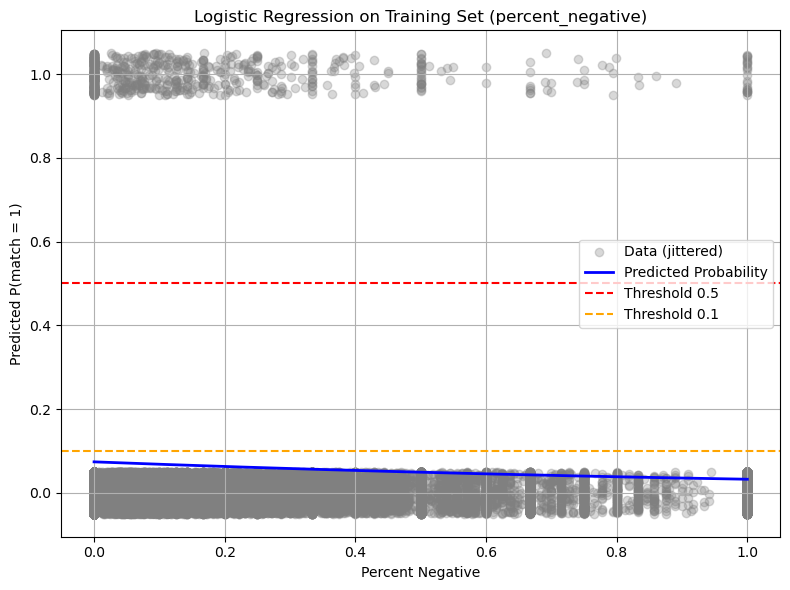

In [174]:
import torch
import torch.nn as nn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score

# -------------------------
# 1. Prepare the data
# -------------------------
X_neg = torch.tensor(df[['percent_negative']].values, dtype=torch.float32)
y_neg = torch.tensor(df['match'].values, dtype=torch.float32).view(-1)

# -------------------------
# 2. Define model, loss, and optimizer
# -------------------------
model_neg = nn.Linear(1, 1)
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]))
optimizer = torch.optim.SGD(model_neg.parameters(), lr=0.01)

# -------------------------
# 3. Train the model
# -------------------------
num_epochs = 5000

for epoch in range(num_epochs):
    model_neg.train()

    logits_neg = model_neg(X_neg).view(-1)
    loss_neg = loss_fn(logits_neg, y_neg)

    optimizer.zero_grad()
    loss_neg.backward()
    optimizer.step()

    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss_neg.item():.4f}")

# -------------------------
# 4. Evaluate the model
# -------------------------
model_neg.eval()
with torch.no_grad():
    logits_neg = model_neg(X_neg).view(-1)
    probs_neg = torch.sigmoid(logits_neg)

threshold = 0.1
y_pred_neg = (probs_neg > threshold).int()
y_true_neg = y_neg.int()

cm_neg = confusion_matrix(y_true_neg, y_pred_neg)
TN_neg, FP_neg, FN_neg, TP_neg = cm_neg.ravel()

precision_neg = precision_score(y_true_neg, y_pred_neg, zero_division=0)
recall_neg = recall_score(y_true_neg, y_pred_neg, zero_division=0)
f1_neg = f1_score(y_true_neg, y_pred_neg, zero_division=0)

print(f"\n🔍 Evaluation at threshold {threshold}")
print(f"TP: {TP_neg}, TN: {TN_neg}, FP: {FP_neg}, FN: {FN_neg}")
print(f"Precision: {precision_neg:.3f}, Recall: {recall_neg:.3f}, F1-score: {f1_neg:.3f}")

# -------------------------
# 5. Compute Loss
# -------------------------
with torch.no_grad():
    percent_negative_loss = loss_fn(logits_neg, y_neg).item()
print(f"\n📉 Final Training Loss (percent_negative): {percent_negative_loss:.4f}")

# -------------------------
# 6. Plot sigmoid curve + data
# -------------------------
x_vals_neg = torch.linspace(df['percent_negative'].min(), df['percent_negative'].max(), 200).view(-1, 1)
with torch.no_grad():
    y_vals_neg = torch.sigmoid(model_neg(x_vals_neg)).view(-1).numpy()

x_scatter_neg = df['percent_negative'].values
y_scatter_neg = df['match'].values + np.random.uniform(-0.05, 0.05, size=len(df))

plt.figure(figsize=(8, 6))
plt.scatter(x_scatter_neg, y_scatter_neg, alpha=0.3, label="Data (jittered)", color='gray')
plt.plot(x_vals_neg.view(-1).numpy(), y_vals_neg, color='blue', linewidth=2, label="Predicted Probability")
plt.axhline(0.5, color='red', linestyle='--', label="Threshold 0.5")
plt.axhline(0.1, color='orange', linestyle='--', label="Threshold 0.1")

plt.xlabel("Percent Negative")
plt.ylabel("Predicted P(match = 1)")
plt.title("Logistic Regression on Training Set (percent_negative)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.preprocessing import StandardScaler

# Select features and target
features = ['avg_rating', 'percent_positive', 'percent_negative']
target = 'match'

# Standardize features
scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[features] = scaler.fit_transform(df_scaled[features])


In [ ]:
import torch.nn as nn

model_3 = nn.Linear(3, 1)  # 3 input features → 1 logit output

# Weighted loss to penalize false negatives
loss_fn = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([10.0]))

# Use Adam optimizer
optimizer = torch.optim.Adam(model_3.parameters(), lr=0.01)

# Regularization strength
l2_lambda = 0.1


In [ ]:


X_3 = torch.tensor(df_scaled[features].values, dtype=torch.float32)
y_3 = torch.tensor(df_scaled[target].values, dtype=torch.float32).view(-1)


In [ ]:
loss_history = []
num_epochs = 1000

for epoch in range(num_epochs):
    model_3.train()
    
    logits = model_3(X_3).view(-1)
    bce_loss = loss_fn(logits, y_3)

    # L2 penalty (exclude bias if desired)
    l2_penalty = sum((param ** 2).sum() for param in model_3.parameters())
    loss = bce_loss + l2_lambda * l2_penalty

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    loss_history.append(loss.item())
    
    if epoch % 100 == 0:
        print(f"Epoch {epoch}, Loss: {loss.item():.4f}")


In [ ]:
model.eval()
with torch.no_grad():
    logits = model_3(X_3).view(-1)
    probs = torch.sigmoid(logits)

print("Logit range:", logits.min().item(), "→", logits.max().item())
print("Probability range:", probs.min().item(), "→", probs.max().item())
print("Predicted 1s at threshold 0.5:", (probs > 0.2).sum().item())


In [ ]:
import torch
from sklearn.metrics import classification_report, confusion_matrix

# Step 1: Prepare the model input (X must be correct for the model)
X_eval = X_3  # or whatever you used: torch.tensor([...])
y_true = torch.tensor(df['match'].values, dtype=torch.int)

# Step 2: Get model predictions
model_3.eval()
with torch.no_grad():
    logits = model_3(X_eval).view(-1)
    probs = torch.sigmoid(logits)

# Step 3: Choose threshold
threshold = 0.2 # or try 0.3, 0.2, etc.
y_pred = (probs > threshold).int()

# Step 4: Evaluate
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:")
print(cm)

print("\nClassification Report:")
print(classification_report(y_true, y_pred, zero_division=0))
